In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# plot style
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

In [ ]:
# folder with timestamped prediction CSVs
pred_dir = Path("../predictions")
pred_files = sorted(pred_dir.glob("predictions_*.csv"), key=lambda p: p.stat().st_mtime)

if not pred_files:
    raise FileNotFoundError("No predictions found. Run predict.py first.")
latest = pred_files[-1]
print("Using predictions file:", latest)

# load data
preds = pd.read_csv(latest)
raw = pd.read_csv("../data/california_example.csv")

# merge in actuals
df = preds.copy()
if "target_log_price" in raw.columns:
    df["ActualPriceUSD"] = np.expm1(raw["target_log_price"])

display(df.head())
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target_log_price,PredictedPriceUSD,ActualPriceUSD
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,13.022766,420180.947715,452600.0
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,12.789687,406832.743394,358500.0
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,12.771673,395344.632057,352100.0
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,12.740520,307874.313359,341300.0
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,12.743154,287324.972303,342200.0


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target_log_price,PredictedPriceUSD,ActualPriceUSD
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,12.084891,203223.076608,206855.816909
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,0.569131,106804.309454,115395.615874
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,9.615805,25125.373647,14999.000000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,11.691916,122613.462468,119600.000000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,12.099050,180979.997438,179700.000000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,12.486451,258393.147486,264725.000000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,13.122367,580219.073067,500001.000000


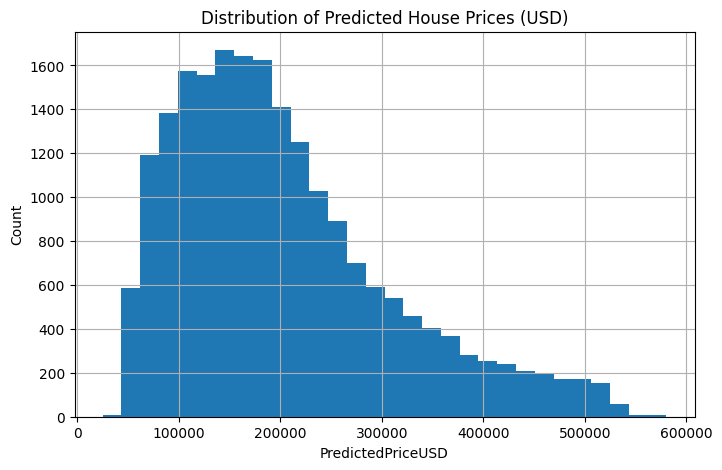

In [ ]:
if "ActualPriceUSD" in df.columns:
    y_true = df["ActualPriceUSD"].to_numpy()
    y_pred = df["PredictedPriceUSD"].to_numpy()

    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    print(f"RMSE: ${rmse:,.0f}")
    print(f"MAE : ${mae:,.0f}")
    print(f"R²  : {r2:.3f}")


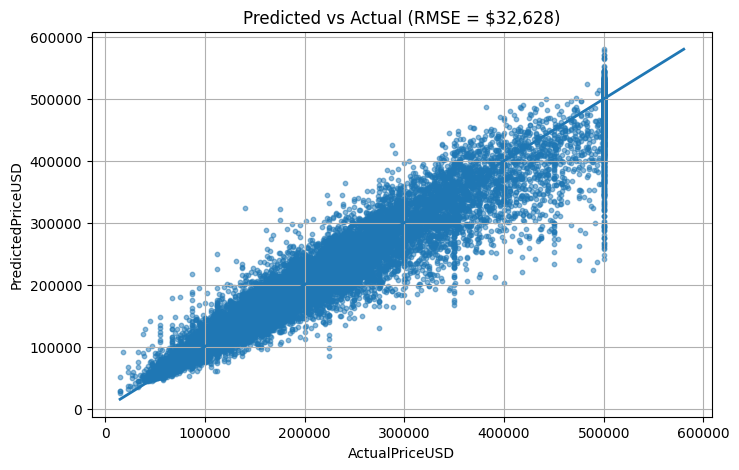

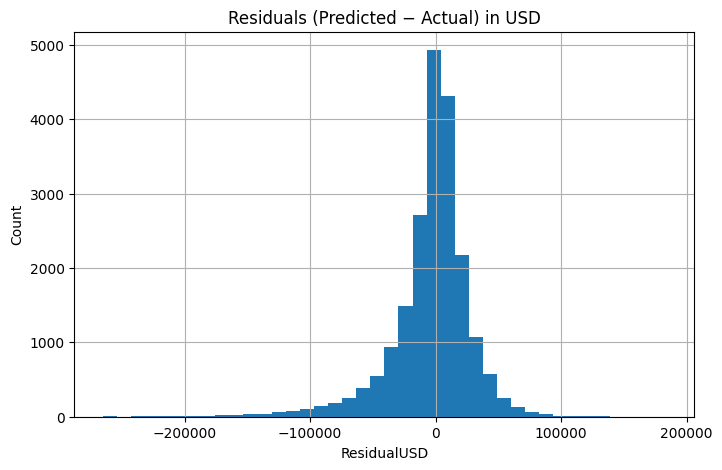

In [ ]:
plt.figure()
plt.hist(df["PredictedPriceUSD"], bins=30)
plt.title("Distribution of Predicted House Prices (USD)")
plt.xlabel("PredictedPriceUSD"); plt.ylabel("Count")
plt.show()


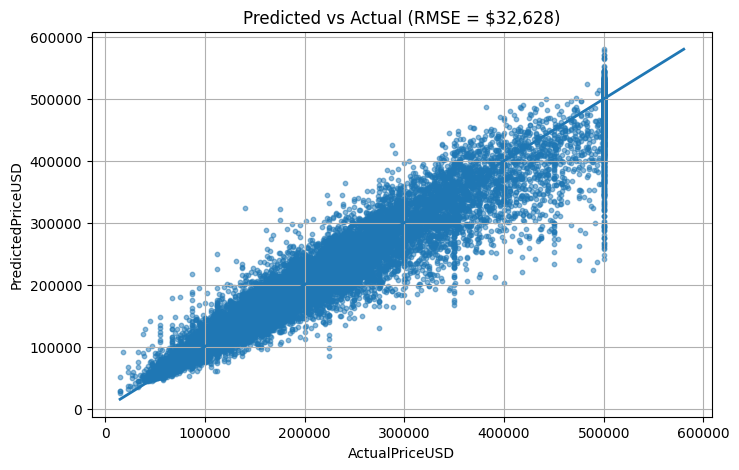

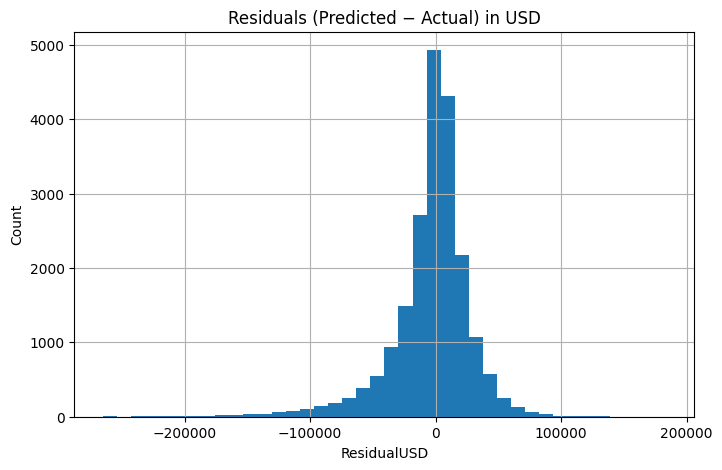

In [ ]:
if "ActualPriceUSD" in df.columns:
    # scatter plot
    plt.figure()
    plt.scatter(df["ActualPriceUSD"], df["PredictedPriceUSD"], s=10, alpha=0.5)
    lo = min(df["ActualPriceUSD"].min(), df["PredictedPriceUSD"].min())
    hi = max(df["ActualPriceUSD"].max(), df["PredictedPriceUSD"].max())
    plt.plot([lo, hi], [lo, hi], linewidth=2, color="red")
    plt.axvline(500_000, linestyle="--", color="grey")  # dataset cap
    plt.title(f"Predicted vs Actual (RMSE = ${rmse:,.0f})")
    plt.xlabel("ActualPriceUSD"); plt.ylabel("PredictedPriceUSD")
    plt.show()

    # residuals
    df["ResidualUSD"] = df["PredictedPriceUSD"] - df["ActualPriceUSD"]
    plt.figure()
    plt.hist(df["ResidualUSD"], bins=40)
    plt.title("Residuals (Predicted − Actual) in USD")
    plt.xlabel("ResidualUSD"); plt.ylabel("Count")
    plt.show()

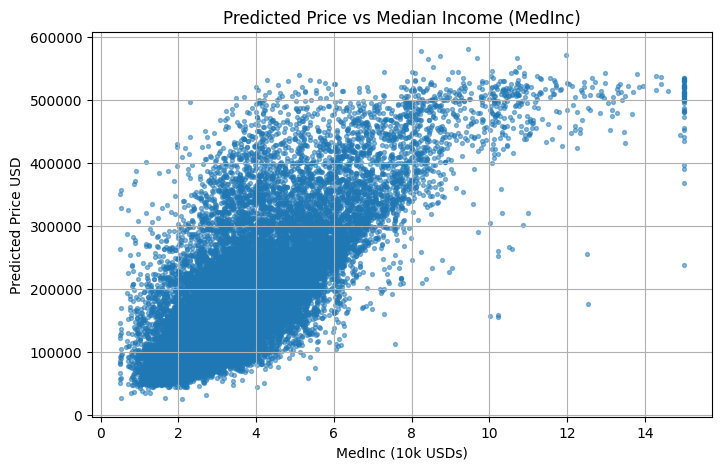

In [ ]:
# Predicted vs Median Income
if "MedInc" in df.columns:
    plt.figure()
    plt.scatter(df["MedInc"], df["PredictedPriceUSD"], s=8, alpha=0.5)
    plt.title("Predicted Price vs Median Income (MedInc)")
    plt.xlabel("Median Income (10k USDs)"); plt.ylabel("Predicted Price (USD)")
    plt.show()

# Geographic view
if {"Latitude", "Longitude"}.issubset(df.columns):
    plt.figure()
    sc = plt.scatter(df["Longitude"], df["Latitude"], c=df["PredictedPriceUSD"], s=6, alpha=0.6)
    plt.colorbar(sc, label="PredictedPriceUSD")
    plt.title("Geography of Predicted Prices")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.show()

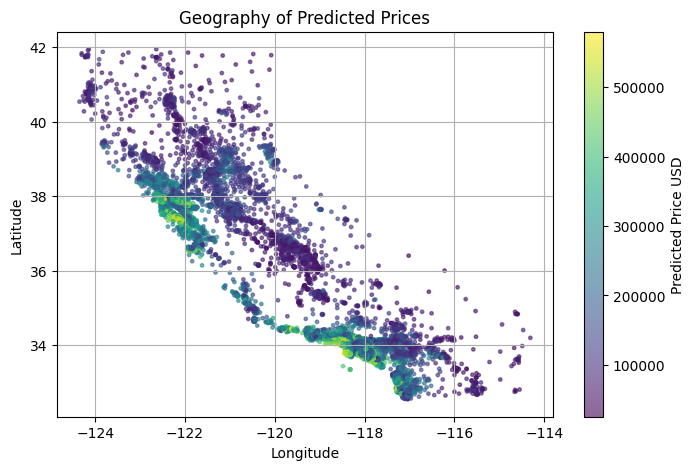

In [12]:
if {"Latitude", "Longitude"}.issubset(df.columns):
    plt.figure()
    sc = plt.scatter(df["Longitude"], df["Latitude"], c=df["PredictedPriceUSD"], s=6, alpha=0.6)
    plt.colorbar(sc, label="Predicted Price USD")
    plt.title("Geography of Predicted Prices")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()